## Import Library

In [6]:
import torch
from model.ResNet import resnet_model
from model.CBAM import cbam_resnet_model
from model.SEnet import senet_model

from data_loader import DataLoaderWrapper
from model.Hyperparameters import Hyperparameters as hp
import matplotlib.pyplot as plt
from model.Util import visualize_cifar10_classes, compute_topk_accuracy, measure_model_efficiency, visualize_attention_maps

## Device configuration

In [7]:
if not torch.cuda.is_available():
    print("CUDA is not available. Profiling will be done on the CPU.")
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Device: ", device)

Device:  cuda


## Initialize data loaders

Files already downloaded and verified
Number of training samples: 50000
Files already downloaded and verified
Number of test samples: 10000
training Data shape: torch.Size([3, 32, 32])
test Data shape: torch.Size([3, 32, 32])


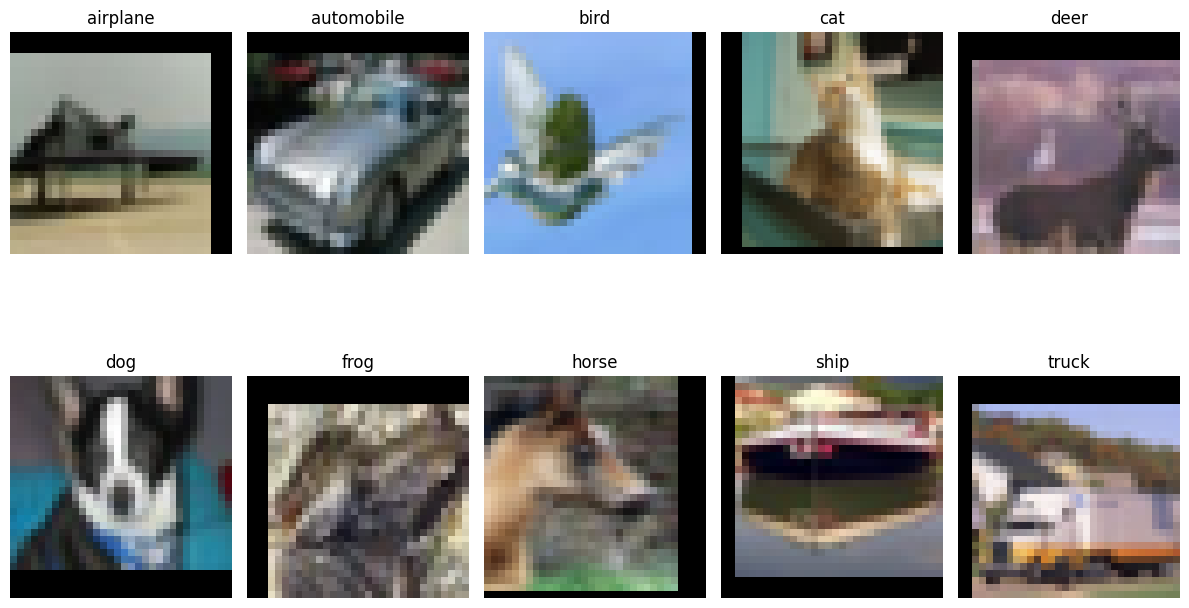

In [8]:
data_loader = DataLoaderWrapper()
train_loader = data_loader.train_loader
val_loader = data_loader.val_loader
test_loader = data_loader.test_loader

visualize_cifar10_classes(train_loader)

## Initialize models

In [9]:
resnet = resnet_model().to(device)
cbam_resnet = cbam_resnet_model().to(device)
senet = senet_model().to(device)

In [10]:
# Metrics Comparison
print("Baseline Model Metrics:")
baseline_efficiency = measure_model_efficiency(resnet, torch.randn(1, 3, 32, 32).to(device), device)
print(f"FLOPS Info: {baseline_efficiency['FLOPS Info']}")
print(f"Memory Usage: {baseline_efficiency['Memory (MB)']} MB")

print("\nCBAM Model Metrics:")
cbam_efficiency = measure_model_efficiency(cbam_resnet, torch.randn(1, 3, 32, 32).to(device), device)
print(f"FLOPS Info: {cbam_efficiency['FLOPS Info']}")
print(f"Memory Usage: {cbam_efficiency['Memory (MB)']} MB")

Baseline Model Metrics:
FLOPS Info: --------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                 model_inference         2.20%       3.345ms       100.00%     151.910ms     151.910ms     244.000us         0.17%     142.523ms     142.523ms             1  
                    aten::conv2d         0.10%     154.500us        13.96%      21.214ms       1.061ms     127.000us         0.09%     135.921ms       6.796ms            20  
               aten::convolution         0.22%     331.700us        13.86%      21.060ms

## Training Model

### A. Training Baseline

In [11]:
# Train ResNet
print("Training ResNet Model")
resnet_metrics = resnet.fit(train_loader, val_loader, device)

Training ResNet Model
Training the model...
Epoch 1/100
Train Loss: 2.1306, Train Acc: 0.2712, Val Loss: 1.6995, Val Acc: 0.3603
Validation loss decreased. Saving model...
Epoch 2/100
Train Loss: 1.5523, Train Acc: 0.4233, Val Loss: 1.5729, Val Acc: 0.4580
Validation loss decreased. Saving model...
Epoch 3/100
Train Loss: 1.3252, Train Acc: 0.5194, Val Loss: 1.3131, Val Acc: 0.5307
Validation loss decreased. Saving model...
Epoch 4/100
Train Loss: 1.1285, Train Acc: 0.5959, Val Loss: 1.2280, Val Acc: 0.5706
Validation loss decreased. Saving model...
Epoch 5/100
Train Loss: 0.9715, Train Acc: 0.6544, Val Loss: 1.0880, Val Acc: 0.6239
Validation loss decreased. Saving model...
Epoch 6/100
Train Loss: 0.8322, Train Acc: 0.7104, Val Loss: 0.8252, Val Acc: 0.7152
Validation loss decreased. Saving model...
Epoch 7/100
Train Loss: 0.7122, Train Acc: 0.7515, Val Loss: 0.8924, Val Acc: 0.6959
EarlyStopping counter: 1 out of 10
Epoch 8/100
Train Loss: 0.6371, Train Acc: 0.7770, Val Loss: 0.7681,

### B. Training CBAM

In [12]:
# Train CBAM ResNet
print("Training CBAM ResNet Model")
cbam_metrics = cbam_resnet.fit(train_loader, val_loader, device)

Training CBAM ResNet Model
Epoch 1/100, Train Loss: 1.9815, Train Acc: 0.2423, Val Loss: 1.7396, Val Acc: 0.3433
Validation loss decreased. Saving model...
Epoch 2/100, Train Loss: 1.4636, Train Acc: 0.4598, Val Loss: 1.4238, Val Acc: 0.4787
Validation loss decreased. Saving model...
Epoch 3/100, Train Loss: 1.1684, Train Acc: 0.5784, Val Loss: 1.2483, Val Acc: 0.5474
Validation loss decreased. Saving model...
Epoch 4/100, Train Loss: 0.9787, Train Acc: 0.6546, Val Loss: 0.9768, Val Acc: 0.6533
Validation loss decreased. Saving model...
Epoch 5/100, Train Loss: 0.8231, Train Acc: 0.7127, Val Loss: 0.9105, Val Acc: 0.6840
Validation loss decreased. Saving model...
Epoch 6/100, Train Loss: 0.7166, Train Acc: 0.7532, Val Loss: 0.7169, Val Acc: 0.7544
Validation loss decreased. Saving model...
Epoch 7/100, Train Loss: 0.6429, Train Acc: 0.7776, Val Loss: 0.6885, Val Acc: 0.7598
Validation loss decreased. Saving model...
Epoch 8/100, Train Loss: 0.5918, Train Acc: 0.7969, Val Loss: 0.7900, 

### C. Training SE-Net

In [13]:
print("Training SEnet Model")
senet_metrics = senet.fit(train_loader,val_loader,device)

Training SEnet Model
Epoch 1/100, Train Loss: 1.6471, Train Acc: 0.3854, Val Loss: 1.5024, Val Acc: 0.4703
Validation loss decreased. Saving model...
Epoch 2/100, Train Loss: 1.1536, Train Acc: 0.5864, Val Loss: 1.2289, Val Acc: 0.5745
Validation loss decreased. Saving model...
Epoch 3/100, Train Loss: 0.8801, Train Acc: 0.6890, Val Loss: 1.1287, Val Acc: 0.6368
Validation loss decreased. Saving model...
Epoch 4/100, Train Loss: 0.7384, Train Acc: 0.7407, Val Loss: 0.8254, Val Acc: 0.7184
Validation loss decreased. Saving model...
Epoch 5/100, Train Loss: 0.6448, Train Acc: 0.7783, Val Loss: 0.7750, Val Acc: 0.7329
Validation loss decreased. Saving model...
Epoch 6/100, Train Loss: 0.5875, Train Acc: 0.7985, Val Loss: 0.6688, Val Acc: 0.7703
Validation loss decreased. Saving model...
Epoch 7/100, Train Loss: 0.5482, Train Acc: 0.8107, Val Loss: 0.8828, Val Acc: 0.7034
EarlyStopping counter: 1 out of 10
Epoch 8/100, Train Loss: 0.5205, Train Acc: 0.8209, Val Loss: 0.6050, Val Acc: 0.792

## Evaluate models on test data


In [14]:
resnet_test_loss, resnet_test_acc = resnet.evaluate(test_loader, device)
cbam_test_loss, cbam_test_acc = cbam_resnet.evaluate(test_loader, device)
senet_test_loss, senet_test_acc = senet.evaluate(test_loader,device)

## Plot for training Result

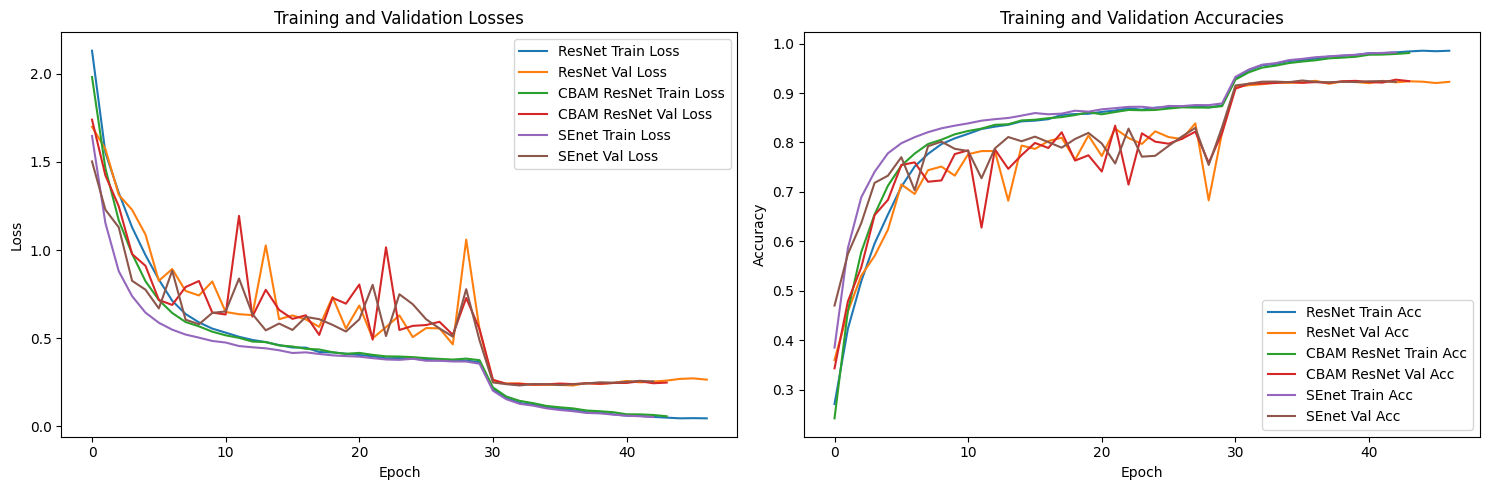

In [15]:
# Compare results
# Plot training and validation losses
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(resnet_metrics['train_losses'], label='ResNet Train Loss')
plt.plot(resnet_metrics['val_losses'], label='ResNet Val Loss')
plt.plot(cbam_metrics['train_losses'], label='CBAM ResNet Train Loss')
plt.plot(cbam_metrics['val_losses'], label='CBAM ResNet Val Loss')
plt.plot(senet_metrics['train_losses'],label='SEnet Train Loss')
plt.plot(senet_metrics['val_losses'],label='SEnet Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(resnet_metrics['train_accuracies'], label='ResNet Train Acc')
plt.plot(resnet_metrics['val_accuracies'], label='ResNet Val Acc')
plt.plot(cbam_metrics['train_accuracies'], label='CBAM ResNet Train Acc')
plt.plot(cbam_metrics['val_accuracies'], label='CBAM ResNet Val Acc')
plt.plot(senet_metrics['train_accuracies'],label='SEnet Train Acc')
plt.plot(senet_metrics['val_accuracies'],label='SEnet Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracies')

plt.tight_layout()
plt.show()

## test accuracy

In [16]:
# Print test accuracies
print(f'ResNet Test Accuracy: {resnet_test_acc:.4f}')
print(f'CBAM ResNet Test Accuracy: {cbam_test_acc:.4f}')
print(f'SEnet Test Accuracy: {senet_test_acc:.4f}')

ResNet Test Accuracy: 0.9197
CBAM ResNet Test Accuracy: 0.9209
SEnet Test Accuracy: 0.9232


## Attention Map

In [17]:
# Attention Map Visualization
print("\nVisualizing CBAM Attention Maps:")
visualize_attention_maps(cbam_resnet, test_loader, device)
visualize_attention_maps(senet,test_loader,device)


Visualizing CBAM Attention Maps:
Model does not have an attention module for visualization.
Model does not have an attention module for visualization.


## Noise test

Files already downloaded and verified
Number of training samples: 50000
Files already downloaded and verified
Number of test samples: 10000
training Data shape: torch.Size([3, 32, 32])
test Data shape: torch.Size([3, 32, 32])
Data use noise: True, use occlusion: True


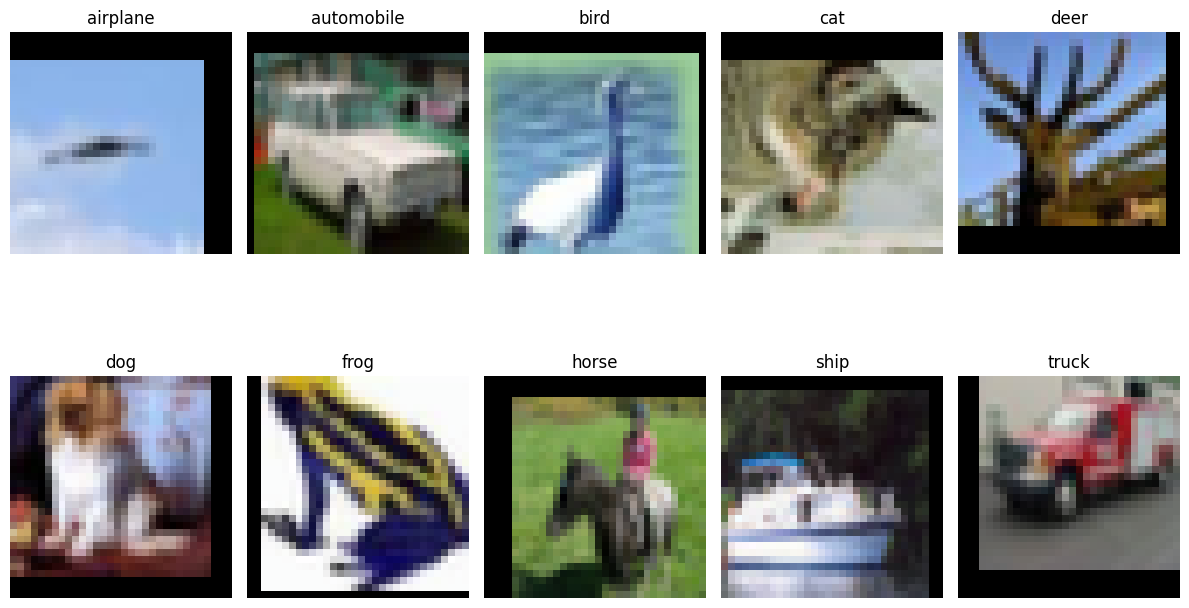

In [18]:
hp.use_noise = True
hp.use_occlusion = True

# Load the data again to apply noise and occlusion
data_loader_Noise = DataLoaderWrapper()
train_loader_Noise = data_loader_Noise.train_loader
val_loader_Noise = data_loader_Noise.val_loader
test_loader_Noise = data_loader_Noise.test_loader

print(f'Data use noise: {hp.use_noise}, use occlusion: {hp.use_occlusion}')


visualize_cifar10_classes(train_loader)

### Initialize Model

In [19]:
resnet_noise = resnet_model().to(device)
cbam_resnet_noise = cbam_resnet_model().to(device)
senet_noise = senet_model().to(device)

### Training model

In [20]:
# Train ResNet
print("Training ResNet Model")
resnet_metrics_noise = resnet.fit(train_loader_Noise, val_loader_Noise, device)

Training ResNet Model
Training the model...
Epoch 1/100
Train Loss: 1.1452, Train Acc: 0.6001, Val Loss: 1.0977, Val Acc: 0.6145
Validation loss decreased. Saving model...
Epoch 2/100
Train Loss: 0.8397, Train Acc: 0.7096, Val Loss: 1.1288, Val Acc: 0.6310
EarlyStopping counter: 1 out of 10
Epoch 3/100
Train Loss: 0.7300, Train Acc: 0.7453, Val Loss: 1.0166, Val Acc: 0.6485
Validation loss decreased. Saving model...
Epoch 4/100
Train Loss: 0.6553, Train Acc: 0.7722, Val Loss: 0.9730, Val Acc: 0.6649
Validation loss decreased. Saving model...
Epoch 5/100
Train Loss: 0.5871, Train Acc: 0.7952, Val Loss: 0.9743, Val Acc: 0.6735
EarlyStopping counter: 1 out of 10
Epoch 6/100
Train Loss: 0.5356, Train Acc: 0.8158, Val Loss: 1.0743, Val Acc: 0.6455
EarlyStopping counter: 2 out of 10
Epoch 7/100
Train Loss: 0.4772, Train Acc: 0.8351, Val Loss: 0.9895, Val Acc: 0.6839
EarlyStopping counter: 3 out of 10
Epoch 8/100
Train Loss: 0.4575, Train Acc: 0.8405, Val Loss: 1.0714, Val Acc: 0.6625
EarlySt

In [16]:
# Train CBAM ResNet
print("Training CBAM ResNet Model")
cbam_metrics_noise = cbam_resnet.fit(train_loader_Noise, val_loader_Noise, device)

Training CBAM ResNet Model
Epoch 1/100, Train Loss: 1.1082, Train Acc: 0.6136, Val Loss: 1.1449, Val Acc: 0.6048
Validation loss decreased. Saving model...
Epoch 2/100, Train Loss: 0.8256, Train Acc: 0.7155, Val Loss: 1.2127, Val Acc: 0.6084
EarlyStopping counter: 1 out of 10
Epoch 3/100, Train Loss: 0.7256, Train Acc: 0.7492, Val Loss: 0.9847, Val Acc: 0.6602
Validation loss decreased. Saving model...
Epoch 4/100, Train Loss: 0.6594, Train Acc: 0.7731, Val Loss: 1.0220, Val Acc: 0.6501
EarlyStopping counter: 1 out of 10
Epoch 5/100, Train Loss: 0.6011, Train Acc: 0.7933, Val Loss: 1.0525, Val Acc: 0.6544
EarlyStopping counter: 2 out of 10
Epoch 6/100, Train Loss: 0.5424, Train Acc: 0.8124, Val Loss: 1.0678, Val Acc: 0.6732
EarlyStopping counter: 3 out of 10
Epoch 7/100, Train Loss: 0.5014, Train Acc: 0.8261, Val Loss: 0.9799, Val Acc: 0.6819
Validation loss decreased. Saving model...
Epoch 8/100, Train Loss: 0.4606, Train Acc: 0.8403, Val Loss: 1.0494, Val Acc: 0.6751
EarlyStopping co

In [24]:
#Train SEnet
print("Training SEnet Model")
senet_metrics_noise = senet.fit(train_loader_Noise,val_loader_Noise,device)

Training SEnet Model
Epoch 1/100, Train Loss: 1.0809, Train Acc: 0.6287, Val Loss: 1.2207, Val Acc: 0.5785
Validation loss decreased. Saving model...
Epoch 2/100, Train Loss: 0.8036, Train Acc: 0.7263, Val Loss: 0.9773, Val Acc: 0.6571
Validation loss decreased. Saving model...
Epoch 3/100, Train Loss: 0.7014, Train Acc: 0.7569, Val Loss: 0.9696, Val Acc: 0.6707
Validation loss decreased. Saving model...
Epoch 4/100, Train Loss: 0.6457, Train Acc: 0.7787, Val Loss: 0.9865, Val Acc: 0.6712
EarlyStopping counter: 1 out of 10
Epoch 5/100, Train Loss: 0.5915, Train Acc: 0.7971, Val Loss: 0.9996, Val Acc: 0.6733
EarlyStopping counter: 2 out of 10
Epoch 6/100, Train Loss: 0.5583, Train Acc: 0.8081, Val Loss: 0.9308, Val Acc: 0.6858
Validation loss decreased. Saving model...
Epoch 7/100, Train Loss: 0.5044, Train Acc: 0.8246, Val Loss: 1.0235, Val Acc: 0.6890
EarlyStopping counter: 1 out of 10
Epoch 8/100, Train Loss: 0.4714, Train Acc: 0.8383, Val Loss: 0.9159, Val Acc: 0.7131
Validation los

### Evaluate model

In [17]:
resnet_test_loss_noise, resnet_test_acc_noise = resnet.evaluate(test_loader_Noise, device)
cbam_test_loss_noise, cbam_test_acc_noise = cbam_resnet.evaluate(test_loader_Noise, device)
senet_test_loss_noise, senet_test_acc_noise = senet.evaluate(test_loader_Noise,device)

### Plot for training Result

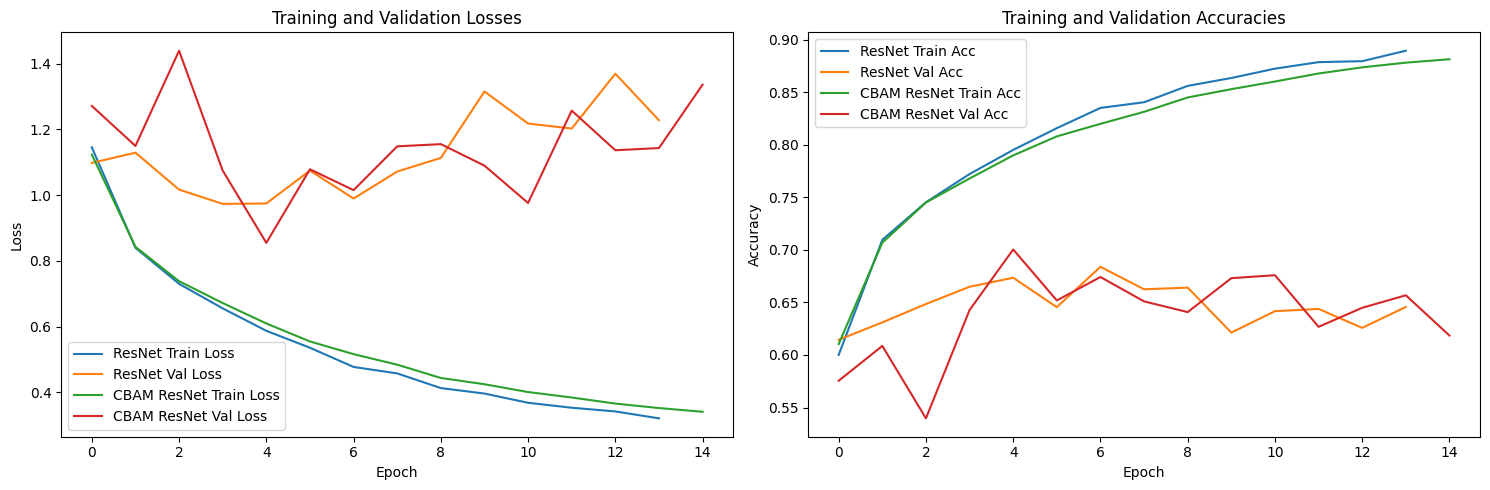

In [18]:
# Compare results
# Plot training and validation losses
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(resnet_metrics_noise['train_losses'], label='ResNet Train Loss')
plt.plot(resnet_metrics_noise['val_losses'], label='ResNet Val Loss')
plt.plot(cbam_metrics_noise['train_losses'], label='CBAM ResNet Train Loss')
plt.plot(cbam_metrics_noise['val_losses'], label='CBAM ResNet Val Loss')
plt.plot(senet_metrics_noise['train_losses'],label='SEnet Train Loss')
plt.plot(senet_metrics_noise['val_losses'],label='SEnet Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(resnet_metrics_noise['train_accuracies'], label='ResNet Train Acc')
plt.plot(resnet_metrics_noise['val_accuracies'], label='ResNet Val Acc')
plt.plot(cbam_metrics_noise['train_accuracies'], label='CBAM ResNet Train Acc')
plt.plot(cbam_metrics_noise['val_accuracies'], label='CBAM ResNet Val Acc')
plt.plot(senet_metrics_noise['train_accuracies'],label='SEnet Train Acc')
plt.plot(senet_metrics_noise['val_accuracies'],label='SEnet Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracies')

plt.tight_layout()
plt.show()

### FLOP Result

In [19]:
# Metrics Comparison
print("Baseline Model Metrics For noise and occlusion:")
baseline_efficiency_noise = measure_model_efficiency(resnet_noise, torch.randn(1, 3, 32, 32).to(device), device)
print(f"FLOPS Info: {baseline_efficiency_noise['FLOPS Info']}")
print(f"Memory Usage: {baseline_efficiency_noise['Memory (MB)']} MB")

print("\nCBAM Model Metrics:")
cbam_efficiency_noise = measure_model_efficiency(cbam_resnet_noise, torch.randn(1, 3, 32, 32).to(device), device)
print(f"FLOPS Info: {cbam_efficiency_noise['FLOPS Info']}")
print(f"Memory Usage: {cbam_efficiency_noise['Memory (MB)']} MB")

print("\nSEnet Model Efficiency")
senet_efficiency_noise = measure_model_efficiency(senet_noise, torch.randn(1, 3, 32, 32).to(device), device)
print(f"FLOPS Info: {senet_efficiency_noise['FLOPS Info']}")
print(f"Memory Usage: {senet_efficiency_noise['Memory (MB)']} MB")


Baseline Model Metrics For noise and occlusion:
FLOPS Info: --------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                 model_inference        26.86%       2.708ms       100.00%      10.084ms      10.084ms       2.328ms        23.03%      10.107ms      10.107ms             1  
                aten::batch_norm         3.10%     312.200us        33.18%       3.345ms     167.270us     266.000us         2.63%       3.568ms     178.400us            20  
    aten::_batch_norm_impl_index         4.00%     403.000us    

## test accuracy

In [20]:
# Print test accuracies
print(f'ResNet Test Accuracy: {resnet_test_acc_noise:.4f}')
print(f'CBAM ResNet Test Accuracy: {cbam_test_acc_noise:.4f}')
print(f'SEnet Test Accuracy: {senet_test_acc_noise:.4f}')

ResNet Test Accuracy: 0.6527
CBAM ResNet Test Accuracy: 0.6123
